#**Import Necessary Libraries**

In [ ]:
# Import Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.applications import efficientnet
import os
import zipfile
from keras.utils import load_img, img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras import models
from keras import layers
from keras import optimizers
from keras import activations
import cv2
import numpy as np
from keras.applications.efficientnet import preprocess_input
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator
import keras
import keras.utils
from keras.regularizers import l2
from numpy import loadtxt, savetxt

In [ ]:
# Extract images folders from zip files locally

local_zip = '/content/drive/MyDrive/Lymph_Cancer/LymphCancerImages.zip'
# local_zip = '/content/drive/MyDrive/Lymph_Cancer/prediction.zip'
# local_zip = '/content/drive/MyDrive/Lymph_Cancer/prediction512.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
# zip_ref.extractall('/content/prediction/')
# zip_ref.extractall('/content/prediction512/')
zip_ref.close()

In [ ]:
# *** FOR 256 ***
!rm -rf "/content/256/test/normal1"
!rm -rf "/content/256/train/normal2"

In [ ]:
# *** FOR 256 ***
base_dir = '/content'

train_dir = os.path.join(base_dir, '256/train')

In [ ]:
# *** FOR 512 ***
!rm -rf "/content/512/test/normal1"
!rm -rf "/content/512/train/normal1"
!rm -rf "/content/512/test/normal2"
!rm -rf "/content/512/train/normal3"

In [ ]:
# *** FOR 512 ***
base_dir = '/content'

train_dir = os.path.join(base_dir, '512/train')

#**Import Pre-Trained Model**

In [ ]:
#Load the EfficientNetB0 model
effnet = efficientnet.EfficientNetB0(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))
effnet.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


#**Create Sequential Model**

In [ ]:
# Create the model
model = models.Sequential()

# Add the efficientnetB0 convolutional base model
model.add(effnet)

# Add new layers
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 81920)             0         
                                                                 
 dense (Dense)               (None, 256)               20971776  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        


#**Data Augmentation and Data Generation**


**Create Function for Hue Augmentation**

In [ ]:
def augment_hue(image):
    # Convert image from BGR to HSV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Generate random hue adjustment
    hue_adjustment = np.random.uniform(-5, 10)

    # Add hue adjustment to image
    image[:, :, 0] = image[:, :, 0] + hue_adjustment

    # Convert image back to BGR
    image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image

#Function to combine hue augmentation and EfficientNetB0 preprocess_input
def preprocess(image):
    # Apply hue adjustment
    image = augment_hue(image)
    # Apply preprocessing
    image = preprocess_input(image)
    return image

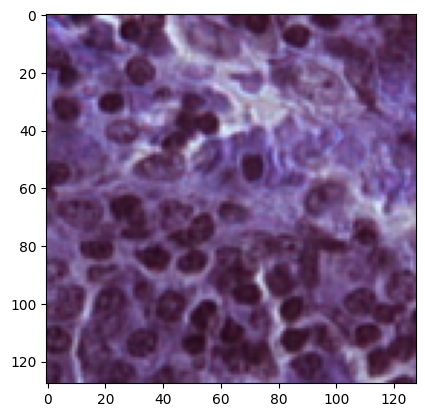

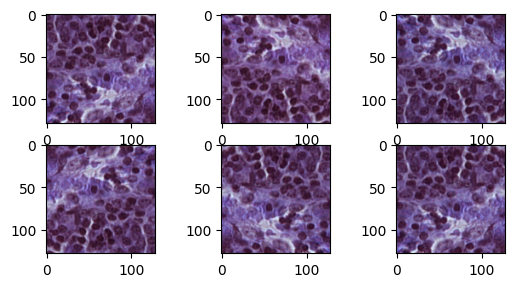

In [ ]:
#VISUALIZE DATA AUGMENTATION

path = '/content/256/train/normal1/10_302_193_normal.png'

img = load_img(path, target_size=(128, 128), grayscale=False, interpolation='bilinear')
plt.imshow(img, cmap='gray')
plt.show()
img_array = img_to_array(img)

# dimesion adjustment
sam = expand_dims(img_array, 0)

# create image data augmentation generator
imageDataGenerator_obj = ImageDataGenerator(preprocessing_function=preprocess,
                                            validation_split=0.2,
                                            horizontal_flip=True,
                                            vertical_flip=True)

# image ploting
iterator = imageDataGenerator_obj.flow(sam, batch_size=32)
for j in range(6):

	plt.subplot(330 + 1 + j)

	chunk = iterator.next()

	sub_img = chunk[0].astype('uint8')

	plt.imshow(sub_img)


plt.show()

In [ ]:
# Generate train(0.8) and validation(0.2) data

train_datagen = ImageDataGenerator(preprocessing_function=preprocess,
                                   validation_split=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=64,
                                                    class_mode='binary',
                                                    target_size=(256,256),
                                                    shuffle=True,
                                                    subset='training', seed=10)

validation_generator = train_datagen.flow_from_directory(train_dir,
                                                         batch_size=64,
                                                         class_mode='binary',
                                                         target_size=(256,256),
                                                         shuffle=True,
                                                         subset='validation', seed=10)

#**Model Training**

In [ ]:
# CALLBACKS
callbackCP = tf.keras.callbacks.ModelCheckpoint(filepath='best_weights',
                                                monitor='val_loss',
                                                mode='auto',
                                                save_best_only=True,
                                                save_weights_only=True,
                                                verbose=1)

callbackES = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              patience=2,
                                              verbose=0,
                                              mode="auto")

In [ ]:
# Remove any existing checkpoints
!rm -r /content/best_weights.index
!rm -r /content/best_weights.data-00000-of-00001
!rm -r /content/checkpoint

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])
# Train the model
history = model.fit(
      train_generator,
      epochs=20,
      callbacks=[callbackCP, callbackES],
      validation_data=validation_generator,
      verbose=1)

# Save the model
#model.save('model.h5')

In [ ]:
# Save model weights in Drive
!cp -r '/content/best_weights.data-00000-of-00001' '/content/drive/MyDrive/Lymph_Cancer/'
!cp -r '/content/best_weights.index' '/content/drive/MyDrive/Lymph_Cancer/'

In [ ]:
# Load model weights
model.load_weights('/content/drive/MyDrive/Lymph_Cancer/best_weights512')

In [ ]:
# Utility function for plotting of the model results

def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


# Run the function to illustrate accuracy and loss
visualize_results(history)

#**Test Accuracy**

In [ ]:
test_datagen  = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True)

test_dir = os.path.join(base_dir, '512/test')

test_generator =  test_datagen.flow_from_directory(test_dir,
                                                   batch_size=32,
                                                   class_mode='binary',
                                                   target_size=(256,256),
                                                   shuffle=False)
loss, acc = model.evaluate(test_generator)
print(f'\n\nAccuracy: {round(acc, 4)*100}%')

#**Make Prediction**

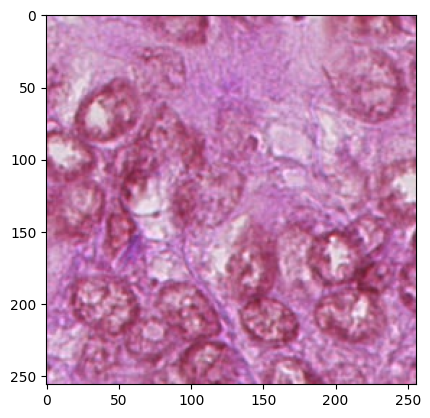

1/1 [==============================] - 10s 10s/step



Softmax Output: [[0.975]]



Image recognised succesfully!


In [ ]:
path = '/content/prediction/tumor_10955.png'
pred_class = 'tumor'

img = load_img(path, target_size=(256, 256), grayscale=False, interpolation='bilinear')
plt.imshow(img, cmap='gray')
plt.show()

x = img_to_array(img)
x = np.expand_dims(x, axis=0)

classes_pred = model.predict(x)
np.set_printoptions(suppress = True, formatter = {'float_kind':'{:.3f}'.format})
print(f'\n\n\nSoftmax Output: {classes_pred}')
if (classes_pred >= 0.5 and pred_class == 'tumor') or (classes_pred <= 0.5 and pred_class == 'normal'):
  print('\n\n\nImage recognised succesfully!')
else:
  print('\n\n\nError! Image not recognised.')

#**WSI Heatmap (for 256)**

**Create array containing all images in a specific order. This is necessary because os.listdir outputs items randomly and we dont want this afterwards.**

In [ ]:
dir = '/content/prediction/'

items = os.listdir(dir)
savetxt('/content/drive/MyDrive/Lymph_Cancer/items.csv', items, delimiter=',', fmt='%s')

In [ ]:
images = loadtxt('/content/drive/MyDrive/Lymph_Cancer/items.csv', delimiter=',', dtype=str)

In [ ]:
size = len(os.listdir('/content/prediction'))
heat = np.zeros(size)
# heat = loadtxt('/content/drive/MyDrive/Lymph_Cancer/heat.csv', delimiter=',')

In [ ]:
print(heat)

**Predict Images and extract metrics**

In [ ]:
dir = '/content/prediction/'

size = len(os.listdir('/content/prediction'))
half = int(size/2)
t_p, f_p, t_n, f_n, cnt = 0, 0, 0, 0, 0

for item in images[:half]:
    split = item.split('_')
    tile_class = split[0]
    items = dir + item
    tile_place = split[1]
    split = tile_place.split('.')
    tile_place = int(split[0]) - 1
    img = load_img(items, target_size=(256, 256), grayscale=False, interpolation='bilinear')
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    classes_pred = model.predict(x, verbose=0)
    np.set_printoptions(suppress = True, formatter = {'float_kind':'{:.3f}'.format})
    heat[tile_place] = classes_pred[0]
    if (classes_pred >= 0.5 and tile_class == 'tumor'):
        t_p += 1
    elif (classes_pred >= 0.5 and tile_class == 'normal'):
        f_p += 1
    elif (classes_pred < 0.5 and tile_class == 'normal'):
        t_n += 1
    else:
        f_n += 1
    cnt += 1
    if cnt % 1000 == 0:
        print('Processing Image No.', cnt)


acc = (t_p + t_n)/(t_p + t_n + f_p + f_n)
print(f'Accuracy: {round(acc, 3)*100}%')
print(f'True Positive Labeled: {t_p}')
print(f'False Positive Labeled: {f_p}')
print(f'True Negative Labeled: {t_n}')
print(f'False Negative Labeled: {f_n}')
savetxt('/content/drive/MyDrive/Lymph_Cancer/heat.csv', heat, delimiter=',')

**Results**

**Model 512-1024 neurons on top (256x256 patches)**

Accuracy: 95.85%

True Positive Labeled: 915

False Positive Labeled: 1625

True Negatives Labeled: 41980

False Negatives Labeled: 237

**Model 256-512**

Accuracy: 95.6%

True Positive Labeled: 917

False Positive Labeled: 1727

True Negatives Labeled: 41878

False Negatives Labeled: 235

In [ ]:
# WSI Heatmap

import seaborn as sns
from numpy import loadtxt

# Load data
map = loadtxt('/content/drive/MyDrive/Lymph_Cancer/map.csv', delimiter=',')
data = loadtxt('/content/drive/MyDrive/Lymph_Cancer/data.csv', delimiter=',')  # (rows, cols, tile_size)
rows = int(data[0])
cols = int(data[1])
tile_size = int(data[2])

beat = 0
for row in range(rows):
    for col in range(cols):
        tile_name = str(row) + "_" + str(col)
        row_start = row * tile_size
        col_start = col * tile_size
        row_end = row_start + tile_size
        col_end = col_start + tile_size
        mapping = map[row_start:row_end, col_start:col_end]
        if not np.any(mapping == 0):
            map[row_start:row_end, col_start:col_end] = heat[beat]
            beat += 1

level6_img = cv2.imread('/content/drive/MyDrive/Lymph_Cancer/tumor_104.png')


hmax = sns.heatmap(map, cmap="jet", alpha=1., zorder=1, xticklabels=False, yticklabels=False)
hmax.imshow(level6_img, alpha=0.3, zorder=2)
plt.show()

#**WSI Heatmap (for 512)**

In [ ]:
dir = '/content/prediction512/'

items512 = os.listdir(dir)
savetxt('/content/drive/MyDrive/Lymph_Cancer/items512.csv', items512, delimiter=',', fmt='%s')

In [ ]:
images = loadtxt('/content/drive/MyDrive/Lymph_Cancer/items512.csv', delimiter=',', dtype=str)

In [ ]:
print(images)

['tumor_2608.png' 'normal_5602.png' 'normal_4355.png' ...
 'normal_1536.png' 'tumor_2936.png' 'normal_4754.png']


In [ ]:
# size = len(os.listdir('/content/prediction512'))
# heat512 = np.zeros(size)
heat512 = loadtxt('/content/drive/MyDrive/Lymph_Cancer/heat512.csv', delimiter=',')

In [ ]:
print(heat512)

[7.65013993e-02 5.19858766e-03 3.07747885e-03 ... 6.76835771e-05
 7.30926040e-05 2.30368692e-03]


In [ ]:
dir = '/content/prediction512/'

size = len(os.listdir('/content/prediction512'))
half = int(size/2)
t_p, f_p, t_n, f_n, cnt = 0, 0, 0, 0, 0

for item in images:
    split = item.split('_')
    tile_class = split[0]
    items = dir + item
    tile_place = split[1]
    split = tile_place.split('.')
    tile_place = int(split[0]) - 1
    img = load_img(items, target_size=(256, 256), grayscale=False, interpolation='bilinear')
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    classes_pred = model.predict(x, verbose=0)
    np.set_printoptions(suppress = True, formatter = {'float_kind':'{:.3f}'.format})
    heat512[tile_place] = classes_pred[0]
    if (classes_pred >= 0.5 and tile_class == 'tumor'):
        t_p += 1
    elif (classes_pred >= 0.5 and tile_class == 'normal'):
        f_p += 1
    elif (classes_pred < 0.5 and tile_class == 'normal'):
        t_n += 1
    else:
        f_n += 1
    cnt += 1
    if cnt % 1000 == 0:
        print('Processing Image No.', cnt)


acc = (t_p + t_n)/(t_p + t_n + f_p + f_n)
print(f'Accuracy: {round(acc, 3)*100}%')
print(f'True Positive Labeled: {t_p}')
print(f'False Positive Labeled: {f_p}')
print(f'True Negative Labeled: {t_n}')
print(f'False Negative Labeled: {f_n}')
savetxt('/content/drive/MyDrive/Lymph_Cancer/heat512.csv', heat512, delimiter=',')

**Results**

**Model 256-512 neurons on top (512x512 patches)**

Accuracy: 98.0%

True Positive Labeled: 209

False Positive Labeled: 168

True Negatives Labeled: 10422

False Negatives Labeled: 53

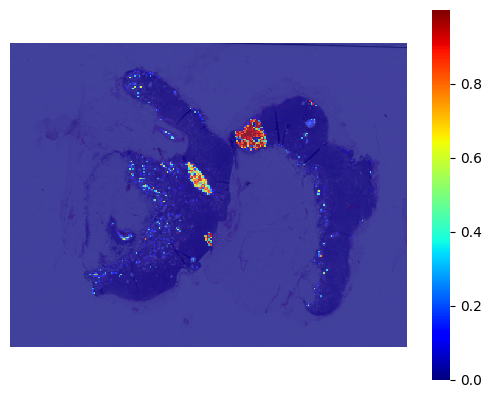

In [ ]:
# WSI Heatmap
import seaborn as sns
from numpy import loadtxt

# Load data
map = loadtxt('/content/drive/MyDrive/Lymph_Cancer/map512.csv', delimiter=',')
data = loadtxt('/content/drive/MyDrive/Lymph_Cancer/data512.csv', delimiter=',')  # (rows, cols, tile_size)
rows = int(data[0])
cols = int(data[1])
tile_size = int(data[2])
calc = int(data[3])

beat = 0
for row in range(rows):
    for col in range(cols):
        tile_name = str(row) + "_" + str(col)
        row_start = row * tile_size
        col_start = col * tile_size
        row_end = row_start + tile_size
        col_end = col_start + tile_size
        mapping = map[row_start:row_end, col_start:col_end]
        if not np.any(mapping == 0):
            map[row_start:row_end, col_start:col_end] = heat512[beat]
            beat += 1

level6_img = cv2.imread('/content/drive/MyDrive/Lymph_Cancer/tumor_104.png')


hmax = sns.heatmap(map, cmap="jet", alpha=1., zorder=1, xticklabels=False, yticklabels=False)
hmax.imshow(level6_img, alpha=0.3, zorder=2)
plt.show()